In [345]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import allel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, cohen_kappa_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline


import umap.umap_ as umap

In [5]:
R_SEED = 22
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

# populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
#               'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
#               'GW','KE','UGgam']

# Using only 12 populations out of 16
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam',
              'GAgam','GHcol','GM','GNgam','GW','KE','UGgam']

# Creating a dictionary of Population names with labels
populations_encoding = {}
for i in range(len(populations)):
    populations_encoding[i] = populations[i]

### Functions to Load, Pre-Process and Analyse the Datasets

In [80]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        self._unlinked_POS = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H,self.P = self.LD_pruning(self.H, self.P, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Haplotype Matrix = ", self.H.shape)
        print("Retained Positions Matrix = ",self.P.shape)
        
        return self.H, self.P
        
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = self.get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = self.get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def LD_pruning(self, gn, pos, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            
            # Returns a boolean array. True(1) - SNPs are within threshold (Unliked), False(0) = Linked
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            
            # Counts non-zero elements = No. of unlinked loci or SNPs to retain
            n = np.count_nonzero(loc_unlinked)
            
            # Calculate the number of SNPs to be removed
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            
            # Select only the unlinked SNPs, i.e., indexes where value is True(1).
            gn = gn.compress(loc_unlinked, axis=0)
            
            # retaining the indexes preserved
            pos = pos.compress(loc_unlinked)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        self._unlinked_POS = pos
        return gn,pos

In [7]:
'''
Disclaimer : The class is for personal use. It is not aimed for portability or reusability.

Class to load and filter the data from disk.
Object Parameters : 
data_path  -> Path to the data directory

load_pop() : Function to load the data
params : 
Populations -> list or array of population names/filenames
filtered -> boolean, whethere to filter the data or not
combine -> Boolean, to combine the populations (Implement it !!!)

returns : A dictionary of haplotype matrix and Position array
'''

class LoadFilteredPops():
    def __init__(self,data_path = None):
        self.data_path = data_path
        
    def load_pop(self,populations,naming='custom',chromo_arms = ['3R'],filtered = True):
        if self.data_path is None:
            home = os.path.expanduser('~')
            directory = os.path.join('Imp_Research','Dataset')
        Haplo_pop = {}
        POS_pop = {}
        for population in populations:
            for arm in chromo_arms:
                pop_name = population+'.'+arm
                if naming == 'custom':
                    filename = f'Haplotype.POS.{pop_name}.hd5'
                else:
                    filename = population
                if self.data_path is None:
                    data_path = os.path.join(home, directory,"HDF_Dataset", filename)
                else:
                    try:
                        data_path = os.path.join(self.data_path,filename)
                    except:
                        print("Cannot resolve Directory path")
                        exit()
                print(f'------{pop_name}------\n')
                H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
                P = pd.read_hdf(data_path,key='POS').to_numpy()
                
                if filtered:
                    # Uses FilterSNP class for filtering steps
                    datafilter = FilterSNP(H,P)
                    Haplo_pop[pop_name],POS_pop[pop_name] = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
                else: 
                    Haplo_pop[pop_name],POS_pop[pop_name] = H,P
                del H,P     
        print("Populations loaded !!!")
        return Haplo_pop,POS_pop

    
'''
Function to combine the populations
Input Params
Haplo_all : Dictionary containing Haplotype matrix for populations. Key-> pop name; Value -> matrix.
            Matrix dimensions must be POS x haplotypes.
POS_all : Position array of SNPs
filtered : Boolean, to filter after combining or not.
get_labels : Boolean, to generate labels

returns
Haplo_all : ndarray of n x m dimensions. n = length of POS array; m = sum of haplotypes from all populations.
POS : SNP Position array
labels : list of labels if Labels = []
'''

# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, 
#                 MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

def combine_pops(H_all,P_all,filtered = True,get_labels = True,LD_window_size = 500, LD_overlap_step = 100,
                 MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=3):
    keys = list(H_all.keys())
    
    # Unpacking the Haplotype matrices of all pops from dictionary
    H = np.array(H_all[keys[0]])
    if len(H_all) > 1:
        for i in range(1,len(H_all)):
            H = np.append(H,H_all[keys[i]],axis=1)
    print('Combined Shape => ',H.shape)
    # Generating Labels if True
    if get_labels:
        label = []
        for each in keys:
            label.extend([each]*len(H_all[each][0]))
                          
    # Returning the combined Haplotype data matrix if Filtered = False
    if filtered == False:
        if get_labels:
            return H,P_all,label
        else:
            return H,p_all
    else:
        # Uses FilterSNP class for filtering steps
        datafilter = FilterSNP(H,P_all)
        H_filtered,POS_filtered = datafilter.all_filters(LD_window_size,LD_overlap_step,MBP_start,MBP_end,
                                                            MAF_threshold,LD_threshold,LD_iter)
        print('Final Filtered Shape = ',H_filtered.shape)
        if get_labels:
            return H_filtered,POS_filtered,label
        else:
            return H_filtered,POS_filtered
        

In [330]:
# EDITED/UPDATED iteratively so usage maybe different at some places
# Function to perform pre-processing and analysis on any two given pair
'''
Parameters : Population 1, Population 2 and SNP Positions
Returns: 1) Filtered data, Filtered SNP Positions, fitted LR object, UMAP fitted LR Object, PCA, PCA loadings
        or
        if just_train_test is True
        2) x_train, x_test, y_train, y_true for the given pair
'''

def pair_analysis(p1, p2, P, just_XY = False, just_train_test = False, patterson = False):

    x = np.append(p1,p2,1)
    print("Shape of samples: ",x.shape)
    fsnp = FilterSNP(x ,P)
    x, P = fsnp.all_filters(LD_window_size = 250,LD_overlap_step = 150,LD_iter = 3)
    
    # to_genotype funtion defined above
    x = to_genotype(x.T)
    print("Shape of samples: ",x.shape)
    y = []
    y.extend([0]*int(len(p1[0])/2))
    y.extend([1]*int(len(p2[0])/2))
    y = np.array(y)
    print("Shape of labels: ",y.shape)
    
    if just_XY:
        return x,y
    
    # Scaling (a bit of cheating because there is no alternatie, AFAIK 😅)
    if patterson:
        x = allel.PattersonScaler().fit_transform(x)
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,stratify=y)
    
    if just_train_test:
        return x_train,x_test, y_train,y_test
    
    lr = LogisticRegression(n_jobs = -1)
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_test)
    # Function defined above
    print(f"LR performance on SNPs: \n")
    evaluate_classifier(y_test,y_pred)
    acc, f1 ,kap = evaluate_classifier(y_test,y_pred)
    print("LR Accuracy: ",acc)
    
    UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
    x_train = UMAP_g.embedding_
    x_test = UMAP_g.transform(x_test)
    
    print(f"LR performance on UMAP components: \n")
    lru = LogisticRegression(n_jobs = -1)
    lru.fit(x_train,y_train)
    y_pred = lru.predict(x_test)
    acc, f1 ,kap = evaluate_classifier(y_test,y_pred)
    print("UMAP-LR Accuracy: ",acc)
    
    UMAP_g = umap.UMAP(n_components = 2,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x)
    
    pca = PCA(n_components = 160).fit(x)
    loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, 160 + 1)],
    index = P)

    
    """
    Loadings being calculated here is score matrix in Singular Value Decomposition.
    D = U * sv * L.T     or    D = U * S * V
    from this,
    SVD score matrix is -> U * sqrt(explained variance)
    U -> Left singular vector, user to class mapping
    SV -> Singular Values,     strength of class
    
    https://stats.stackexchange.com/questions/346692/how-does-eigenvalues-measure-variance-along-the-principal-components-in-pca
    """
    
    return x, lr, lru, UMAP_g, pca, loadings, P

### Loading Dataset

In [8]:
# Loading dataset into the memory using the custom loader classes above
# Stored into dictionaries

loader = LoadFilteredPops()
Haplo_all, POS_all = loader.load_pop(populations,filtered = False)

------BFcol.3R------

------BFgam.3R------

------AOcol.3R------

------CIcol.3R------

------CMgam.3R------

------GAgam.3R------

------GHcol.3R------

------GM.3R------

------GNgam.3R------

------GW.3R------

------KE.3R------

------UGgam.3R------

Populations loaded !!!


In [310]:
H_allF, POS_allF, pop_labels = combine_pops(Haplo_all,POS_all['BFcol.3R'],filtered = True, MAF_threshold = 3)

Combined Shape =>  (4836295, 2186)
1.) Selecting Mega Base Pairs
iteration 1 retaining 158382 removing 126234 variants
iteration 2 retaining 157263 removing 1119 variants
iteration 3 retaining 157217 removing 46 variants
Retained Haplotype Matrix =  (157217, 2186)
Retained Positions Matrix =  (157217,)
Final Filtered Shape =  (157217, 2186)


#### Downsampling CMgam

In [77]:
H = Haplo_all.copy()

# Find the indexes  of CMgam
cmgam = H['CMgam.3R']
# Retaining only first 100 samples (200 Haplotypes)
H['CMgam.3R'] = cmgam[:,:200]
print('Shape of CMgam: ',H['CMgam.3R'].shape)

Shape of CMgam:  (4836295, 200)


#### Converting Haplotypes into Genotypes

In [58]:
for key in H.keys():
    X = H[key].T
    X_g = []
    for i in range(0,len(X),2):
        X_g.append(X[i]+X[i+1])
    X_g = np.array(X_g)
    H[key] = X_g
    print(f'{key} transformed shape: \t{X_g.shape}')

BFcol.3R transformed shape: 	(75, 4836295)
BFgam.3R transformed shape: 	(92, 4836295)
AOcol.3R transformed shape: 	(78, 4836295)
CIcol.3R transformed shape: 	(71, 4836295)
CMgam.3R transformed shape: 	(100, 4836295)
GAgam.3R transformed shape: 	(69, 4836295)
GHcol.3R transformed shape: 	(55, 4836295)
GM.3R transformed shape: 	(65, 4836295)
GNgam.3R transformed shape: 	(40, 4836295)
GW.3R transformed shape: 	(91, 4836295)
KE.3R transformed shape: 	(48, 4836295)
UGgam.3R transformed shape: 	(112, 4836295)


### Analysis Script

In [73]:
def to_genotype(X):
    Xg = []
    for i in range(0,len(X),2):
        Xg.append(X[i]+X[i+1])
    return np.array(Xg)

def evaluate_classifier(y_true,y_pred):
    test_accuracy = accuracy_score(y_true,y_pred)
    f1w = f1_score(y_true,y_pred,average= 'weighted')
    kappa = cohen_kappa_score(y_true,y_pred)
    return test_accuracy, f1w, kappa

In [ ]:
'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Store Filtering stats for all the pairs
3. Haplo to Geno and Train-Test Split
4. Classifying using Logistic Regression and LDA
5. Generating UMAP visualization
6. Dimensionality Reduction: Obtaining 20 UMAP components 
7. Training LR classifier on UMAP components
8. Dumping all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []

# Edited to do damage control ! 
for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
#         ppos_filt = len(pair_pos)
        
        # 3. Haplo to Geno and Train-Test Split
        X = pair_h.T
        Xg = to_genotype(X)       #Genotype data
        pshape_g = Xg.shape
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= R_SEED)
        
        # 4. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 5. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(populations)
        plt.title(f'Genotype populations {pname} UMAP. metric = euclidean,neighbors = 15,min-dist = 2,spread = 5');
        figname = f'{count}_{pname}_umap.png'
        path = os.path.join(directory,'pairwise_plots',figname)
        plt.savefig(path,dpi=100)
        plt.show() 
        # calling plt.show() before saving clears all the graph
        
        # 6. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit(x_train)
        x_train = UMAP_g.embedding_
        x_test = UMAP_g.transform(x_test)
        
        # 7. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_train,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_test))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
    
pairwise_analysis = pd.DataFrame()
pairwise_analysis['Count'] = range(1,len(pnames)+1)
pairwise_analysis['Population_pair'] = pnames
pairwise_analysis['Samples'] = psamples
pairwise_analysis['Initial_SNP'] = psnps_init
pairwise_analysis['MAF_filter_SNP'] = pmaf
pairwise_analysis['Filtered_SNP'] = psnps_filt
pairwise_analysis['LR_accuracy'] = accuracy_lr
pairwise_analysis['LR_f1score'] = f1score_lr
pairwise_analysis['LR_kappa'] = kappa_lr
pairwise_analysis['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysis['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysis['UMAP_LR_kappa'] = kappa_ulr

# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) took test size 80% (-_-)(*_*)


print(pairwise_analysis)
path = os.path.join(directory,'Pairwise_Analysis_Stats.csv')
pairwise_analysis.to_csv(path,index= False)


In [128]:
path = os.path.join(directory,'Pairwise_Analysis_Stats_Euclidean_UMAP.csv')
pairwise_analysis.to_csv(path,index= False)

In [127]:
pairwise_analysis.head(50)

,Count,Population_pair,Samples,Initial_SNP,MAF_filter_SNP,Filtered_SNP,LR_accuracy,LR_f1score,LR_kappa,UMAP_LR_accuracy,UMAP_LR_f1score,UMAP_LR_kappa
0,1,BFcol_BFgam,167.0,4836295,202928,116947,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,BFcol_AOcol,153.0,4836295,196218,61477,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,3,BFcol_CIcol,146.0,4836295,206852,91924,1.000000,1.000000,1.000000,0.966667,0.966630,0.933333
3,4,BFcol_CMgam,175.0,4836295,200832,117855,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,5,BFcol_GAgam,144.0,4836295,218226,52373,1.000000,1.000000,1.000000,0.896552,0.895047,0.791367
5,6,BFcol_GHcol,130.0,4836295,209195,99782,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,7,BFcol_GM,140.0,4836295,213948,95080,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,8,BFcol_GNgam,115.0,4836295,200373,111014,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,9,BFcol_GW,166.0,4836295,206882,111254,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,10,BFcol_KE,123.0,4836295,192085,21719,1.000000,1.000000,1.000000,0.400000,0.228571,0.000000


In [ ]:
# IMPROVISED ANALYSIS SCRIPT
# UPDATES ADDED - 1) Saves SNP positions 2) Added Patterson Scaler 3) Added PCA+LR classification stats

'''
Pairwise analysis of all the 12 populations.
Total 66 combinations/analysis
Analysis includes:
1. Selecting a pair
2. Filtering the SNPs jointly
    - Mega Base Pair Selection
    - Rare Allele Filtering with MAF >= 5%
    - LD Pruning
    Save Filtering stats for all the pairs
3. Convert Haplotype to Genotype
4. Patterson Scaling
5. Train-Test Split
6. Classifying using Logistic Regression and LDA
7. Generating UMAP visualization
8. Dimensionality Reduction: Obtaining 20 UMAP components 
9. Training LR classifier on UMAP components
10. Dimensionality Reduction: Obtaining 50 PCA components
11. Training LR classifier on PCA components
12. Storing all the stats and evaluation scores into a dataframe
'''
# Storage Path
home = home = os.path.expanduser('~')
directory = os.path.join(home,'Imp_Research','Repository','Pairwise_Analysis')

# List of keys
keys = list(H.keys())
count = 0
pnames = []
psamples = []
pmaf = []
psnps_init = []
psnps_filt = []
accuracy_lr = []
f1score_lr = []
kappa_lr = []
accuracy_ulr = []
f1score_ulr = []
kappa_ulr = []
accuracy_plr = []
f1score_plr = []
kappa_plr = []
snp_pos = {} 

for i in range(11):
    for j in range(i+1,12):
        count+=1
        pair_pos = POS_all[keys[i]]
        # 1. Pair Selection. Combining the populations. 
        pop1 = H[keys[i]]
        pop2 = H[keys[j]]
        pair_h = np.append(pop1,pop2,1)
        pname = f'{keys[i][:-3]}_{keys[j][:-3]}'
        pnames.append(pname)
        psnps_init.append(pair_h.shape[0])
        psamples.append(pair_h.shape[1]/2)
        print(f'{pname}\n{psnp_init}')
        
        # 2. Filtering (Using FilterSNP class) Taking window size 250 is quicker.
        fsnp = FilterSNP(pair_h,pair_pos)
        pair_h, pair_pos = fsnp.all_filters(LD_window_size = 250,LD_overlap_step = 100,LD_iter = 3)
        psnps_filt.append(pair_h.shape[0])
        pmaf.append(fsnp._retained_maf)
        snp_pos[pname] = pair_pos
    
        # 3. Converting Haplo to Geno
        X = pair_h.T
        Xg = to_genotype(X)       # Func to obtain Genotype
        pshape_g = Xg.shape
        
        # 4. Patterson Scaling
#         Xg = allel.PattersonScaler().fit_transform(Xg)
        
        # 5. Train-Test Split
        Y = [0]*int(len(pop1[0])/2)
        Y.extend([1]*int(len(pop2[0])/2))
        Y = np.array(Y)
        print("Unique Labels: ",np.unique(Y))
        print(f"{pname[:5]} : {len(np.where(Y==0)[0])}, {pname[5:]} : {len(np.where(Y==1)[0])}")
        x_train,x_test,y_train,y_test = train_test_split(Xg,Y,test_size = 0.2,stratify = Y,random_state= 22)
        
        # 6. LR Classifier
        lr = LogisticRegression(n_jobs = -1)
        lr.fit(x_train,y_train)
        acc_lr, f1w_lr, kap_lr = evaluate_classifier(y_test,lr.predict(x_test))
        accuracy_lr.append(acc_lr)
        f1score_lr.append(f1w_lr)
        kappa_lr.append(kap_lr)
        
        # 7. Generate UMAP visualization
        UMAP_g = umap.UMAP(n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(Xg)
        sns.set(style='white')
        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(UMAP_g[:, 0],UMAP_g[:, 1],c=Y,cmap='coolwarm')
        plt.setp(ax, xticks=[], yticks=[])
        cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
        cbar.set_ticks(np.arange(2))
        cbar.set_ticklabels(pname.split('_'))
        plt.title(f'Genotype populations {pname} UMAP. Metric = jaccard,neighbors = 15,min-dist = 2,spread = 5');
#         figname = f'{count}_{pname}_umap.png'
#         path = os.path.join(directory,'pairwise_plots','pairwise_jaccard_patterson_plots',figname)
#         plt.savefig(path,dpi=100)
        plt.show() 
        # NOTE !!! Calling plt.show() before saving clears the figure so empty graph will be saved
        
        # 8. Dimensionality Reduction: Obtaining 20 umap components
        UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
        x_utrain = UMAP_g.embedding_
        x_utest = UMAP_g.transform(x_test)
        
        # 9. Training LR on UMAP components
        ulr = LogisticRegression(n_jobs = -1)
        ulr.fit(x_utrain,y_train)
        acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_utest))
        accuracy_ulr.append(acc_ulr)
        f1score_ulr.append(f1w_ulr)
        kappa_ulr.append(kap_ulr)
        
        
        # 10. Dimensionality Reduction: Obtaining 50 PCA components
        pca = PCA(n_components = 50)
        pca.fit(x_train)
        x_ptrain = pca.transform(x_train)
        x_ptest = pca.transform(x_test)
        
        # 11. Training LR on UMAP components
        plr = LogisticRegression(n_jobs = -1)
        plr.fit(x_ptrain,y_train)
        acc_plr, f1w_plr, kap_plr = evaluate_classifier(y_test,plr.predict(x_ptest))
        accuracy_plr.append(acc_plr)
        f1score_plr.append(f1w_plr)
        kappa_plr.append(kap_plr)
    
pairwise_analysisJ = pd.DataFrame()
pairwise_analysisJ['Count'] = range(1,len(pnames)+1)
pairwise_analysisJ['Population_pair'] = pnames
pairwise_analysisJ['Samples'] = psamples
pairwise_analysisJ['Initial_SNP'] = psnps_init
pairwise_analysisJ['MAF_filter_SNP'] = pmaf
pairwise_analysisJ['Filtered_SNP'] = psnps_filt
pairwise_analysisJ['LR_accuracy'] = accuracy_lr
pairwise_analysisJ['LR_f1score'] = f1score_lr
pairwise_analysisJ['LR_kappa'] = kappa_lr
pairwise_analysisJ['UMAP_LR_accuracy'] = accuracy_ulr
pairwise_analysisJ['UMAP_LR_f1score'] = f1score_ulr
pairwise_analysisJ['UMAP_LR_kappa'] = kappa_ulr
pairwise_analysisJ['PCA_LR_accuracy'] = accuracy_plr
pairwise_analysisJ['PCA_LR_f1score'] = f1score_plr
pairwise_analysisJ['PCA_LR_kappa'] = kappa_plr

# OLD ERROR LOG - Ignore!
# Errored at i = 5, j = 8, count = 48, pname = 'GAgam_GNgam'
# status: UMAP saved but no data. Also 20 components exceeded some samples.
# because I messed up (-_-) and took test size 80% (*_*)


print(pairwise_analysisJ)
path = os.path.join(directory,'Pairwise_Analysis_Stats_Jaccard_UMAP_PCA.csv')
pairwise_analysisJ.to_csv(path,index= False)


# RUN AGAIN WITHOUT PATTERSON PLEASEEEEEEE. Patterson scaling messes up UMAP functioning.
# DONE ^^^

In [320]:
# Saving SNP Positions of all the pairs as a pickle file
import pickle as pkl

path = os.path.join(directory,'POS_Pairwise_Analysis_Jaccard_UMAP_PCA.csv')
with open(path,'wb') as f:
    pkl.dump(snp_pos,f)

In [135]:
pairwise_analysisJ.head(50)

# LD_window = 500, overlap = 150 -> SNP = 116947
# LD_window = 250, overlap = 100 -> SNP = 117141

,Count,Population_pair,Samples,Initial_SNP,MAF_filter_SNP,Filtered_SNP,LR_accuracy,LR_f1score,LR_kappa,UMAP_LR_accuracy,UMAP_LR_f1score,UMAP_LR_kappa
0,1,BFcol_BFgam,167.0,4836295,202928,116947,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,2,BFcol_AOcol,153.0,4836295,196218,61477,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,3,BFcol_CIcol,146.0,4836295,206852,91924,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
3,4,BFcol_CMgam,175.0,4836295,200832,117855,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
4,5,BFcol_GAgam,144.0,4836295,218226,52373,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
5,6,BFcol_GHcol,130.0,4836295,209195,99782,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
6,7,BFcol_GM,140.0,4836295,213948,95080,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
7,8,BFcol_GNgam,115.0,4836295,200373,111014,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
8,9,BFcol_GW,166.0,4836295,206882,111254,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
9,10,BFcol_KE,123.0,4836295,192085,21719,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


## JACCARD is BETTER !!! 😎

### BFgam vs CMgam with Patterson scaled data

In [137]:
H.keys()

dict_keys(['BFcol.3R', 'BFgam.3R', 'AOcol.3R', 'CIcol.3R', 'CMgam.3R', 'GAgam.3R', 'GHcol.3R', 'GM.3R', 'GNgam.3R', 'GW.3R', 'KE.3R', 'UGgam.3R'])

In [152]:
bfgam = H['BFgam.3R']
cmgam = H['CMgam.3R']
x_bfcm = np.append(bfgam,cmgam,1)
x_bfcm.shape

(4836295, 384)

In [153]:
fsnp = FilterSNP(x_bfcm,POS_all['BFgam.3R'])
x_bfcm, p_bfcm = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 384)
2.) Filtering Rare Allels
Number of SNPs removed =  3449831
Retaining =  201889
3.) Performing LD Pruning
iteration 1 retaining 114364 removing 87525 variants
iteration 2 retaining 113491 removing 873 variants
iteration 3 retaining 113461 removing 30 variants
Retained Haplotype Matrix =  (113461, 384)
Retained Positions Matrix =  (113461,)


In [154]:
x_bfcm = to_genotype(x_bfcm.T)
x_bfcm.shape

(192, 113461)

In [148]:
y_bfcm = []
y_bfcm.extend([0]*92)
y_bfcm.extend([1]*100)
y_bfcm = np.array(y_bfcm)

In [163]:
x_bfcm = allel.PattersonScaler().fit_transform(x_bfcm)

In [191]:
x_train,x_test,y_train,y_test = train_test_split(x_bfcm,y_bfcm,test_size=0.20,stratify=y_bfcm)

In [162]:
# Doesn't work. IDK Why ? Will figure out later!

# pscaler = allel.PattersonScaler().fit(x_train)
# x_train = pscaler.transform(x_train)
# x_test = pscaler.transform(x_test)

ValueError: operands could not be broadcast together with shapes (48,113461) (144,1) (48,113461) 

In [168]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
evaluate_classifier(y_test,y_pred)

# (Accuracy, F1Score, Kappa)

(0.9230769230769231, 0.9224635829286992, 0.845442536327609)

In [194]:
UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
x_train = UMAP_g.embedding_
x_test = UMAP_g.transform(x_test)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


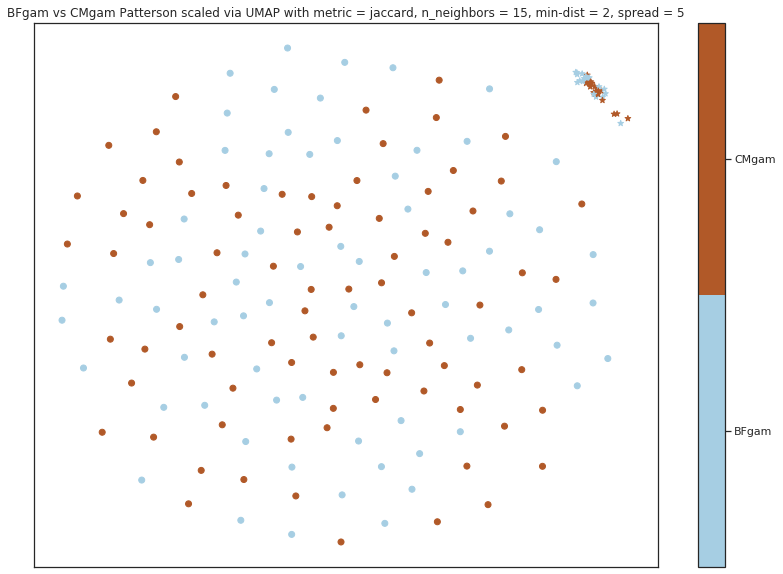

In [193]:
UMAP_g = umap.UMAP(n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x_bfcm)


sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      x_train[:, 0],
      x_train[:, 1],
      c=y_train,cmap='Paired')
plt.scatter(
      x_test[:, 0],
      x_test[:, 1],
      c=y_test,cmap='Paired',marker='*')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['BFgam','CMgam'])
plt.title('BFgam vs CMgam Patterson scaled via UMAP with metric = jaccard, n_neighbors = 15, min-dist = 2, spread = 5');

In [170]:
lru = LogisticRegression(n_jobs = -1)
lru.fit(x_train,y_train)
y_pred = lru.predict(x_test)
evaluate_classifier(y_test,y_pred)

(0.5384615384615384, 0.46367521367521375, 0.05898123324396798)

#### BFgam vs GNgam Patterson scaled analysis

In [179]:
bfgam = H['BFgam.3R']
gngam = H['GNgam.3R']
x_bfgn = np.append(bfgam,gngam,1)
x_bfgn.shape

fsnp = FilterSNP(x_bfgn,POS_all['BFgam.3R'])
x_bfgn, p_bfcm = fsnp.all_filters(LD_window_size = 500,LD_overlap_step = 150,LD_iter = 3)

x_bfgn = to_genotype(x_bfgn.T)

y_bfgn = []
y_bfgn.extend([0]*92)
y_bfgn.extend([1]*40)
y_bfgn = np.array(y_bfgn)

x_bfgn = allel.PattersonScaler().fit_transform(x_bfgn)

x_train,x_test,y_train,y_test = train_test_split(x_bfgn,y_bfgn,test_size=0.20,stratify=y_bfgn)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 107740 removing 95707 variants
iteration 2 retaining 105927 removing 1813 variants
iteration 3 retaining 105816 removing 111 variants
Retained Haplotype Matrix =  (105816, 264)
Retained Positions Matrix =  (105816,)


In [180]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
evaluate_classifier(y_test,y_pred)

(0.7407407407407407, 0.6600823045267489, 0.1674008810572687)

In [181]:
UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
x_train = UMAP_g.embedding_
x_test = UMAP_g.transform(x_test)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/spectral.py:344: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


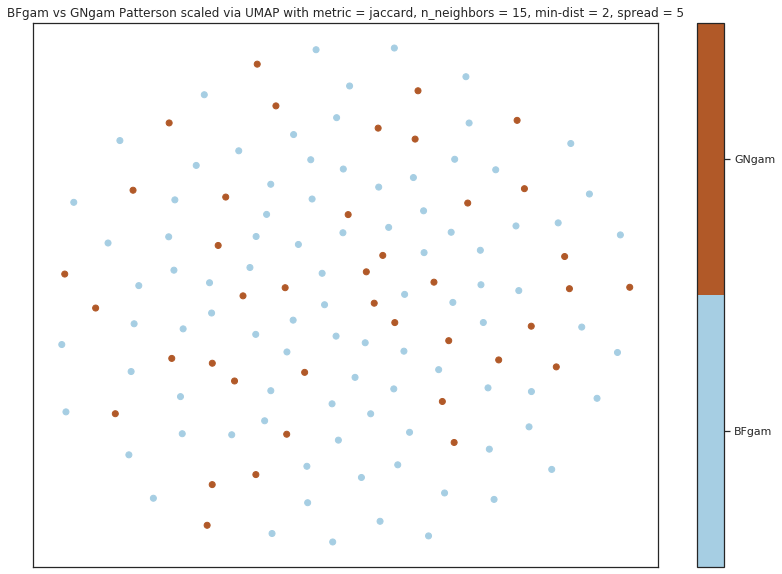

In [184]:
UMAP_g = umap.UMAP(n_components = 2,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit_transform(x_bfgn)


sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=y_bfgn,cmap='Paired')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['BFgam','GNgam'])
plt.title('BFgam vs GNgam Patterson scaled via UMAP with metric = jaccard, n_neighbors = 15, min-dist = 2, spread = 5');

### Feature Importance Exploration

In [224]:
lr, lru, umap, pca, loadings, pos = pair_analysis(H['BFcol.3R'],H['BFgam.3R'],POS_all['BFcol.3R'])

Shape of samples:  (4836295, 334)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 118764 removing 84164 variants
iteration 2 retaining 117373 removing 1391 variants
iteration 3 retaining 117130 removing 243 variants
Retained Haplotype Matrix =  (117130, 334)
Retained Positions Matrix =  (117130,)
Shape of samples:  (167, 117130)
Shape of labels:  (167,)
LR performance on SNPs: 



/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


LR performance on UMAP components: 



/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [235]:
plt.style.use('seaborn')

In [302]:
# Edited the function pair_analysis to only obtain PCA 

pca160 = pair_analysis(H['BFcol.3R'],H['BFgam.3R'],POS_all['BFcol.3R'])

Shape of samples:  (4836295, 334)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 118764 removing 84164 variants
iteration 2 retaining 117373 removing 1391 variants
iteration 3 retaining 117130 removing 243 variants
Retained Haplotype Matrix =  (117130, 334)
Retained Positions Matrix =  (117130,)
Shape of samples:  (167, 117130)
Shape of labels:  (167,)


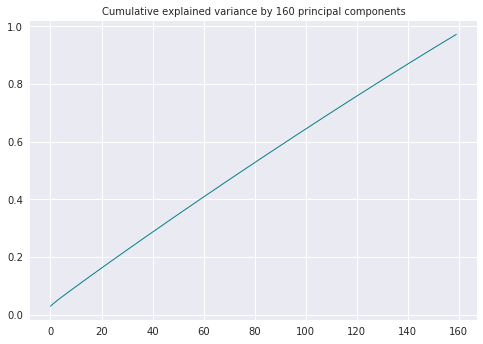

In [306]:
plt.plot(pca160.explained_variance_ratio_.cumsum(), lw=1, color='#087E8B')
plt.title('Cumulative explained variance by 160 principal components', size=10)
plt.show()

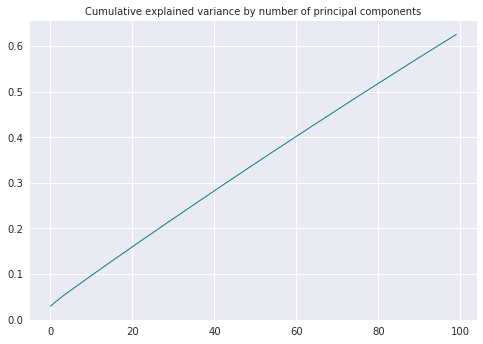

In [236]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=1, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=10)
plt.show()

In [250]:
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
46609,0.348945,-0.037285,0.013033,-0.002422,-0.013380,0.036689,0.062825,-0.015140,-0.040410,-0.041999,...,-0.022884,0.074897,0.051003,0.056375,0.036114,-0.120455,-0.065105,-0.062797,0.036365,0.003328
48634,-1.308082,-0.057333,-0.134159,0.073471,0.061353,-0.086621,0.003485,-0.055152,-0.130855,-0.039451,...,0.074253,0.080805,0.145935,-0.046876,0.037815,-0.027769,-0.100013,0.008761,0.034449,-0.215814
49078,0.300165,0.010268,0.001076,0.021137,0.055201,-0.020872,-0.030298,0.068852,-0.065039,-0.003823,...,-0.048509,-0.017436,0.100103,0.047649,-0.085007,-0.068054,0.025541,0.060324,-0.047725,-0.003732
49448,-0.379737,-0.073808,0.149828,0.053135,-0.090703,0.101538,-0.042306,0.069179,0.025860,0.011952,...,-0.032737,-0.123344,-0.033712,0.007799,0.014061,-0.189199,-0.008852,-0.047861,0.019486,-0.021829
50174,0.420523,0.018726,0.040891,0.033453,-0.047848,-0.026575,0.021636,-0.015278,0.043634,0.013024,...,-0.041342,-0.010968,0.051465,-0.026935,0.152780,0.081053,-0.030274,-0.045984,0.025187,0.039810


In [255]:
pc1_loadings['CorrelationWithPC1'][:100]

# Look more into it for explaination!!??
# Loading exceeds 1

0     1.561858
1     1.323784
2     1.320482
3     1.298034
4     1.214922
        ...   
95    0.863297
96    0.863265
97    0.862374
98    0.861085
99    0.860691
Name: CorrelationWithPC1, Length: 100, dtype: float64

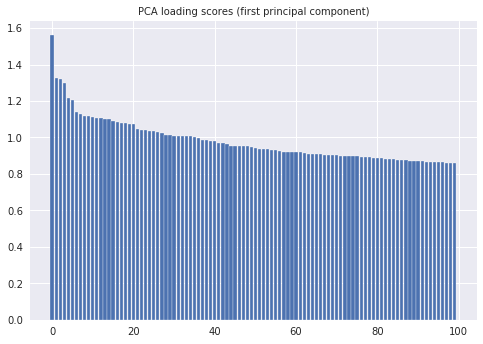

In [259]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=range(100), height=pc1_loadings['CorrelationWithPC1'][:100])
plt.title('PCA loading scores (first principal component)', size=10)
plt.show()

In [265]:
pc1_loadings.head(10)

,Attribute,CorrelationWithPC1
0,23464378,1.561858
1,30250951,1.323784
2,27117897,1.320482
3,28336532,1.298034
4,30389635,1.214922
5,26902297,1.207015
6,21272371,1.142346
7,30336767,1.130886
8,27063377,1.120346
9,26852697,1.116241


In [263]:
importances = pd.DataFrame(data={
    'Attribute': pos,
    'Importance': lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

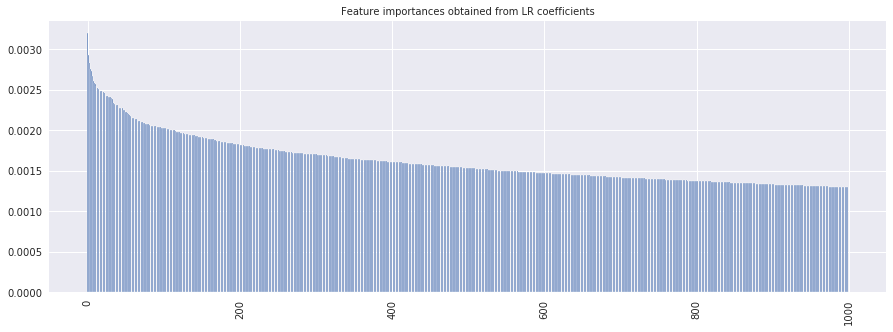

In [268]:
plt.figure(figsize=(15,5))
plt.bar(x=range(1000), height=importances['Importance'][:1000])
plt.title('Feature importances obtained from LR coefficients', size=10)
plt.xticks(rotation='vertical')
plt.show()

#### Row Sum of PCA loadings

In [269]:
component_sum = loadings.sum(axis=1)
component_sum.head(10)

46609    0.591527
48634   -0.988471
49078    0.138213
49448   -0.347043
50174    0.935846
51321    0.074756
52653   -2.408102
68502    0.641599
69500    0.676100
70029    1.207544
dtype: float64

In [271]:
# Sorted Row Sum
component_sum.sort_values(ascending=False).head(10)

8158845     5.021647
21454348    4.758976
31701009    4.546670
24620653    4.510589
26450256    4.474714
5141000     4.231206
9289314     4.216904
27966302    4.213657
27960521    4.211747
3494637     4.142069
dtype: float64

In [275]:
# Sorted Absolute Row Sum
components_absum = component_sum.abs().sort_values(ascending=False)
components_absum.head(10)

8158845     5.021647
19468526    4.992548
5151792     4.899084
20903938    4.881799
26716641    4.796021
5218680     4.773948
21454348    4.758976
7321631     4.721378
554053      4.551268
31701009    4.546670
dtype: float64

In [276]:
# 29920 SNPs with absolute sum of coeffs > 1
# We can attempt to train a classifier on these ?

len(components_absum.loc[components_absum > 1])

29920

In [293]:
components_absum.loc[components_absum > 1].tail(3)

22112383    1.000035
1149196     1.000018
4224773     1.000006
dtype: float64

Values of Coeffs across multiple components

In [285]:
# Contribution of SNP = 8158845 across components
loadings.loc[8158845].sort_values(ascending=False).head(10)

PC43    0.323813
PC30    0.282132
PC44    0.254644
PC39    0.233702
PC72    0.224531
PC53    0.222391
PC34    0.212942
PC5     0.208725
PC74    0.203116
PC77    0.199036
Name: 8158845, dtype: float64

In [295]:
# Contribution of SNP = 4224773 across components
loadings.loc[4224773].sort_values(ascending=False).head(10)

PC12    0.224971
PC41    0.186301
PC11    0.179123
PC46    0.173212
PC33    0.165076
PC37    0.148195
PC88    0.132505
PC78    0.127423
PC82    0.118327
PC79    0.115282
Name: 4224773, dtype: float64

Similar Analysis on complete dataset

### UMAP variability analysis via repeated trials

In [325]:
# Population Pairs taken to conduct the experiment are :
# 1) BFgam_BFcol  2) CICol_GHcol  3) BFgam_GNgam

# Edited the function pair_analysis() to Obtain 
# the Train-Test Split : 80-20

# x: data/samples; y: labels/population

x_train_bf, x_test_bf, y_train_bf, y_test_bf = pair_analysis(H['BFcol.3R'],H['BFgam.3R'],POS_all['BFcol.3R'], just_train_test=True)
x_train_ci, x_test_ci, y_train_ci, y_test_ci = pair_analysis(H['CIcol.3R'],H['GHcol.3R'],POS_all['CIcol.3R'], just_train_test=True)
x_train_gn, x_test_gn, y_train_gn, y_test_gn = pair_analysis(H['BFgam.3R'],H['GNgam.3R'],POS_all['GNgam.3R'], just_train_test=True)

Shape of samples:  (4836295, 334)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 334)
2.) Filtering Rare Allels
Number of SNPs removed =  3448792
Retaining =  202928
3.) Performing LD Pruning
iteration 1 retaining 118764 removing 84164 variants
iteration 2 retaining 117373 removing 1391 variants
iteration 3 retaining 117130 removing 243 variants
Retained Haplotype Matrix =  (117130, 334)
Retained Positions Matrix =  (117130,)
Shape of samples:  (167, 117130)
Shape of labels:  (167,)
Shape of samples:  (4836295, 252)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 252)
2.) Filtering Rare Allels
Number of SNPs removed =  3437390
Retaining =  214330
3.) Performing LD Pruning
iteration 1 retaining 72959 removing 141371 variants
iteration 2 retaining 68047 removing 4912 variants
iteration 3 retaining 67663 removing 384 variants
Retained Haplotype Matrix =  (67663, 252)
Retained Positions Matrix =  (67663,)
Shape of samples:  (126, 67663)
Sh

In [326]:
# Hyperparameters for UMAP:
metric = 'jaccard'   # to calculate distance between two samples
n_components = 20    # UMAP components to use
n_neighbors = 15     # Number of neighbors to consider per sample
min_dist = 2         # Distance between the samples in lower-dimensional layout
spread = 5           # Spread of clusters over layout

# Choice of Hyperparameters depends on experiments conducted so far, pariwise analysis results, AG1000 2020 paper and so on

# YET TO CONDUCT A HYPERPARAMETER TUNING or SWEEP!
 

In [ ]:
# Function to get UMAP fitted LR accuracy for a given pair
def get_umap_lr(x_train,x_test,y_train,y_test):
    #Obtaining UMAP components for the given data
    UMAP_g = umap.UMAP(n_components = 20,n_neighbors=15,metric='jaccard',min_dist=2,spread=5).fit(x_train)
    x_utrain = UMAP_g.embedding_
    x_utest = UMAP_g.transform(x_test)

    # Training LR on UMAP components
    ulr = LogisticRegression(n_jobs = -1)
    ulr.fit(x_utrain,y_train)
    
    # Obtaining accuracies
    acc_ulr, f1w_ulr, kap_ulr = evaluate_classifier(y_test,ulr.predict(x_utest))
    return acc_ulr

acc_bfbf = []
acc_cigh = []
acc_bfgn = []

# Classification is run for 500 times and accuracies are recorded for all three pairs
for i in range(500):
    # Accuracy of Pair 1) BFgam_BFcol  
    acc = get_umap_lr(x_train_bf, x_test_bf, y_train_bf, y_test_bf)
    acc_bfbf.append(acc)
    
    # Accuracy of Pair 2) CICol_GHcol
    acc = get_umap_lr(x_train_ci, x_test_ci, y_train_ci, y_test_ci)
    acc_cigh.append(acc)
    
    # Accuracy of Pair 3) BFgam_GNgam
    acc = get_umap_lr(x_train_gn, x_test_gn, y_train_gn, y_test_gn)
    acc_bfgn.append(acc)
    
    print("Iteration: ",i+1)

In [385]:
umap_trials = pd.DataFrame()
umap_trials['BFgam_BFcol'] = acc_bfbf
umap_trials['CIcol_GHcol'] = acc_cigh
umap_trials['BFgam_GNgam'] = acc_bfgn

In [386]:
umap_trials.head(10)

,BFgam_BFcol,CIcol_GHcol,BFgam_GNgam
0,1.0,0.961538,0.703704
1,1.0,0.961538,0.740741
2,1.0,1.000000,0.703704
3,1.0,1.000000,0.703704
4,1.0,0.961538,0.703704
5,1.0,1.000000,0.703704
6,1.0,1.000000,0.666667
7,1.0,1.000000,0.666667
8,1.0,0.961538,0.703704
9,1.0,0.961538,0.703704


Text(0.5, 1.0, 'Accuracy over 500 UMAP-LR runs')

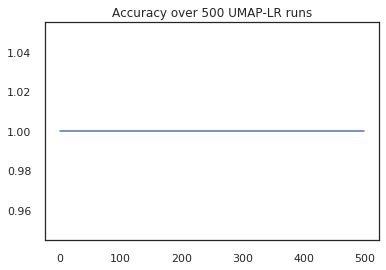

In [403]:
plt.plot(range(500),acc_bfbf)
plt.title("Accuracy over 500 UMAP-LR runs")

Text(0.5, 1.0, 'Accuracy over 500 UMAP-LR runs for BFgam_BFcol')

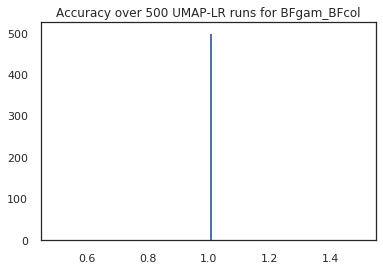

In [420]:
plt.hist(acc_bfbf,width = 0.01)
plt.title("Accuracy over 500 UMAP-LR runs for BFgam_BFcol")

Text(0.5, 1.0, 'Accuracy over 500 UMAP-LR runs for CIcol_GHcol')

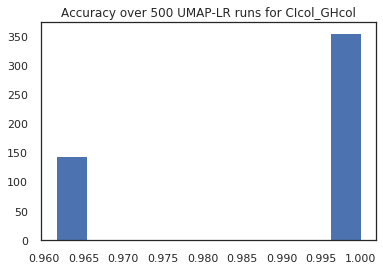

In [416]:
plt.hist(acc_cigh)
plt.title("Accuracy over 500 UMAP-LR runs for CIcol_GHcol")

Text(0.5, 1.0, 'Accuracy over 500 UMAP-LR runs CIcol_GHcol')

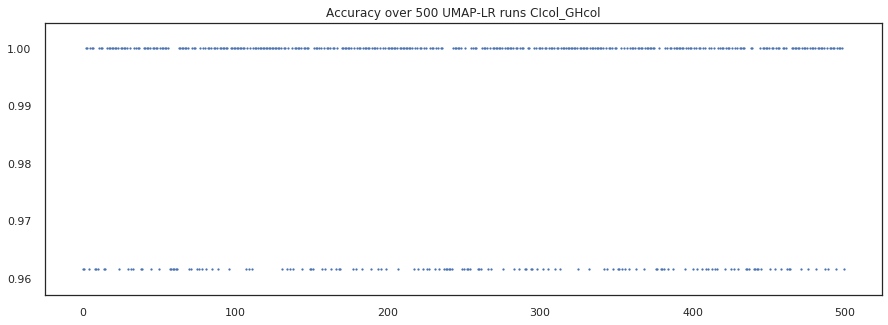

In [429]:
plt.figure(figsize=(15,5))
plt.scatter(range(500),acc_cigh,s=1.5)
plt.title("Accuracy over 500 UMAP-LR runs CIcol_GHcol")

(array([0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76]),
 <a list of 8 Text xticklabel objects>)

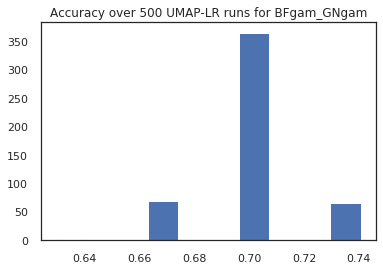

In [413]:
plt.hist(acc_bfgn)
plt.title("Accuracy over 500 UMAP-LR runs for BFgam_GNgam")
plt.xticks()

Text(0.5, 1.0, 'Accuracy over 500 UMAP-LR runs BFgam_GNgam')

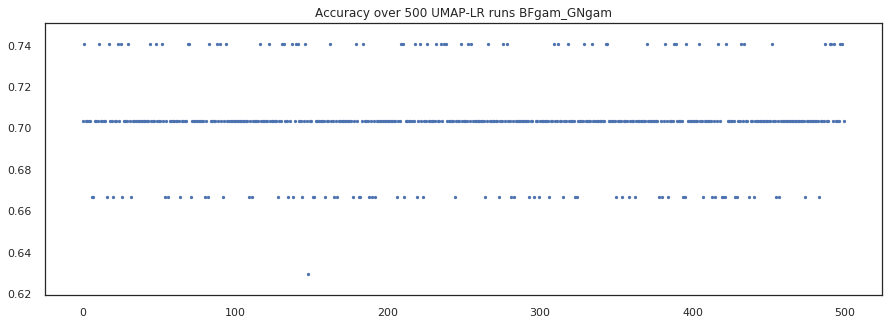

In [435]:
plt.figure(figsize=(15,5))
plt.scatter(range(500),acc_bfgn, s=5)
plt.title("Accuracy over 500 UMAP-LR runs BFgam_GNgam")

In [ ]:
'''
Conclusion : There is a high possibility that this is happening due to descent optimization.
More or less, the algorithm is not able to reach the global optima every time !
'''

### Some experiments with BFgam vs GNgam

In [332]:
x_bfgn,y_bfgn = pair_analysis(H['BFgam.3R'],H['GNgam.3R'],POS_all['GNgam.3R'], just_XY=True)

Shape of samples:  (4836295, 264)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 264)
2.) Filtering Rare Allels
Number of SNPs removed =  3448273
Retaining =  203447
3.) Performing LD Pruning
iteration 1 retaining 109545 removing 93902 variants
iteration 2 retaining 106672 removing 2873 variants
iteration 3 retaining 106252 removing 420 variants
Retained Haplotype Matrix =  (106252, 264)
Retained Positions Matrix =  (106252,)
Shape of samples:  (132, 106252)
Shape of labels:  (132,)


In [336]:
# BFgam - 92
# GNgam - 40
# Balancing them out

X = x_bfgn[52:]
Y = y_bfgn[52:]
X.shape

(80, 106252)

In [361]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.20,stratify=Y)

In [364]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)
y_pred = lr.predict(x_test)
evaluate_classifier(y_test,y_pred)

(0.6875, 0.6761133603238867, 0.375)

In [357]:
print(y_pred)
print(y_test)

[1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0]
[1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0]


In [347]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix

array([[6, 2],
       [2, 6]])

In [378]:
cvlr = cross_validate(lr,X,Y,cv=10,return_train_score=True)
print("Average score :",sum(cvlr['test_score'])/10)

0.6375


Text(0.5, 1.0, 'Accuracy of LR on BFgam_GNgam over 10-Fold CV')

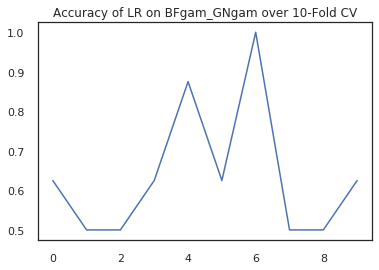

In [383]:
plt.plot(range(10),cvlr['test_score'],label='Test')
plt.title("Accuracy of LR on BFgam_GNgam over 10-Fold CV")

Text(0.5, 1.0, 'Accuracy of LR on BFgam_GNgam over 20-Fold CV')

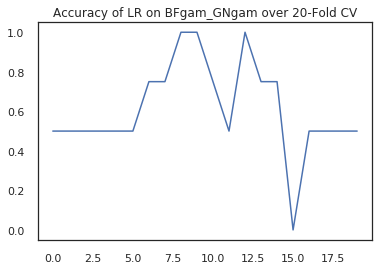

In [375]:
cvlr = cross_validate(lr,X,Y,cv=20)
plt.plot(range(20),cvlr['test_score'])
plt.title("Accuracy of LR on BFgam_GNgam over 20-Fold CV")

In [371]:
acc_lr_bfgn = []
for i in range(10):
    #x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.20,stratify=Y)
    lr = LogisticRegression()
    cvlr = cross_validate(lr,X,Y,cv=10)
    acc_lr_bfgn.extend(cvlr['test_score'])

Text(0.5, 1.0, 'Accuracy of LR on BFgam_GNgam over 10 10-Fold CV')

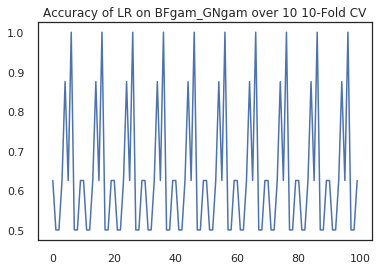

In [373]:
plt.plot(range(100),acc_lr_bfgn)
plt.title("Accuracy of LR on BFgam_GNgam over 10 10-Fold CV")